


# Surface Event Analysis
###### This notebook analyzes surface event waveforms on Mt Rainier and calculates location, directivity, and velocity, it is updated from the previous as the gridsearch algorithm is weighted by slope,and it analyzes labeled events
###### Francesca Skene
###### fskene@uw.edu
###### Created: 5/23/23

Import Modules

In [1]:
import sys
sys.path.append('/data/wsd01/pnwstore/')
import matplotlib.pyplot as plt
from matplotlib.pyplot import Figure
import numpy as np
import pandas as pd
import obspy
from obspy.core import UTCDateTime
from obspy.clients.fdsn.client import Client
from obspy.geodetics import *
from obspy.signal.cross_correlation import *
from obspy.signal.trigger import classic_sta_lta
from obspy.core.utcdatetime import UTCDateTime
import requests
import glob
from pnwstore.mseed import WaveformClient
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy
from scipy import optimize
from scipy.optimize import curve_fit
from geopy import distance
import datetime
import rasterio as rio
from rasterio.plot import show
from rasterio.merge import merge
import richdem as rd
from pathlib import Path
from pyproj import Proj,transform,Geod
import os 
from scipy.interpolate import RectBivariateSpline
import json
import matplotlib
from zipfile import ZipFile

Parameters

In [2]:
# define clients to download the station data
client = WaveformClient()
client2 = Client('IRIS')

t_before = 120 #number of seconds before pick time
t_after = 120 #number of seconds after pick time
fs = 40 #sampling rate that all waveforms are resampled to
window = 30 #window length of the signal
pr = 98 #percentile
thr = 12 #SNR threshold
station_distance_threshold = 25
pi = np.pi
v_s = 1000 #shear wave velocity at the surface

# range of dates that we are looking at
t_beginning = UTCDateTime(2001,1,1,0,0,0) 
t_end = UTCDateTime(2021,12,31,23,59)

smooth_length = 5 # constant for smoothing the waveform envelopes
low_cut = 2 #low frequency threshold
high_cut = 12 #high frequency threshold
az_thr = 1000 #threshold of distance in meters from source location
step = 100 #step every 100 m
t_step = 1 #step every second
ratio = 5.6915196 #used to define the grid 
colors = list(plt.cm.tab10(np.arange(10)))*3
radius = 6371e3 # radius of the earth

## Define Functions

In [3]:
#define a function that calculates picktimes at each station
def pick_time(time, ref_env, data_env_dict, st, t_diff, t_before, fs):
    # time; picktime from the PNSN
    # ref_env; reference envelope
    # data_env_dict; dictionary of the envelope data, key is the network+station
    # st; stream of traces of the waveforms
    # t_diff; 120
    # t_before; 120
    # fs sample rate
    pick_times,offsets, starttimes = [],[],[]
    for i,key in enumerate(data_env_dict):
        starttimes.append(st[i].stats.starttime)
        xcor = correlate(data_env_dict[key],ref_env,int(50*fs))
        index = np.argmax(xcor)
        cc = round(xcor[index],9) #correlation coefficient
        shift = 50*fs-index #how much it is shifted from the reference envelope
        offset_time = time - shift/fs # shift from one envelope to the reference envelope in seconds
        offsets.append(offset_time) # number of seconds from the beginning of the trace
        pick_times.append(offset_time + 120)
    return pick_times, offsets, starttimes

# calculate the 
def shift(offsets, starttimes, t_diff):
    shifts, vals =[],[]
    for i,ii in enumerate(t_diff):
        t_shift = offsets[i]-min(offsets)
        vals.append((-1*t_diff[ii])+t_shift)
        shifts.append(t_shift)
    return shifts, vals



# resamples the data
def resample(st, fs):
    for i in st:
        i.detrend(type='demean')
        i.taper(0.05)
        i.resample(fs)   
    return st

# calculate number of surface events per month
def events_per_month(starttimes, events):
    num_events = {}
    for year in range (2001, 2021):
        for month in range (1, 13):
            Nevt = []
            period = str(year)+"_"+str(month)
            t0 = UTCDateTime(year, month, 1)
            t1 = t0+3600*24*30
            for i in range(0, len(starttimes)):
                if t0<starttimes[i]<t1:
                    Nevt.append(events[i])
            if len(Nevt) != 0:
                num_events[period]=len(Nevt)
            if len(Nevt) == 0:
                num_events[period] = 0

    periods = list(num_events.keys())
    num_of_events = list(num_events.values())
    return periods, num_of_events

# fit data to a cosine curve
def test_func(theta, a,theta0, c):
    return a * np.cos(theta-theta0)+c

# make plots of weighted data
def weight_data(x_data,y_data,weight,test_func,v_s,stas):    
    #weighting the data
    tempx, tempy = [],[]
    for i,ii in enumerate(x_data):
        tempx.append([])
        tempx[i].append([ii for l in range(0,weight[i])])
        tempy.append([])
        tempy[i].append([y_data[i] for l in range(0,weight[i])])   
    weighted_x = sum(sum(tempx, []),[])
    weighted_y = sum(sum(tempy, []),[])
   
    #optimizing parameters to fit weighted data to test_function
    params, params_covariance = optimize.curve_fit(test_func, np.deg2rad(weighted_x), weighted_y, p0=None)
    d = test_func(np.deg2rad(x_points), params[0], params[1], params[2])
    if params[0]<0:
        direction = params[1]+pi 
    else:
        direction = params[1]   
    fmax = max(d)
    fmin = min(d)
    v = v_s*((fmax-fmin)/(fmax+fmin))
    return v, direction, d

# predict synthetic arrival times
def travel_time(t0, x, y, vs, sta_x, sta_y):
    dist = np.sqrt((sta_x - x)**2 + (sta_y - y)**2)
    tt = t0 + dist/vs
    return tt

# compute residual sum of squares
def error(synth_arrivals,arrivals, weight):
    res = (arrivals - synth_arrivals)* weight 
    res_sqr = res**2
    mse = np.mean(res_sqr)
    rmse = np.sqrt(mse)
    return rmse

# iterate through grid and calculate travel time residuals
def gridsearch(t0,x_vect,y_vect,sta_x,sta_y,vs,arrivals, weight):
    rss_mat = np.zeros((len(t0),len(x_vect),len(y_vect)))
    rss_mat[:,:,:] = np.nan
    for i in range(len(t0)):
        for j in range(len(x_vect)):
            for k in range(len(y_vect)):
                synth_arrivals = []
                for h in range(len(sta_x)):
                    tt = travel_time(t0[i],x_vect[j],y_vect[k],vs,sta_x[h],sta_y[h])
                    synth_arrivals.append(tt)
                rss = error(np.array(synth_arrivals),np.array(arrivals), np.array(weight))
                rss_mat[i,j,k] = rss
    return rss_mat

# find lower-left corner of grid and grid size based on height of volcano
def start_latlon(elevation, ratio, center_lat, center_lon):
    side_length = elevation * ratio
    l = side_length/2
    hypotenuse = l*np.sqrt(2)
    d = distance.geodesic(meters = hypotenuse)
    start_lat = d.destination(point=[center_lat,center_lon], bearing=225)[0]
    start_lon = d.destination(point=[center_lat,center_lon], bearing=225)[1]
    return start_lat, start_lon, side_length

# convert the location index into latitude and longitude
def location(x_dist, y_dist, start_lat, start_lon):
    bearing = 90-np.rad2deg(np.arctan(y_dist/x_dist)) 
    dist = np.sqrt((x_dist)**2 + (y_dist)**2)
    d = distance.geodesic(meters = dist)
    loc_lat = d.destination(point=[start_lat,start_lon], bearing=bearing)[0]
    loc_lon = d.destination(point=[start_lat,start_lon], bearing=bearing)[1]
    return loc_lat, loc_lon, d

# find diameter in meters of the error on the location
def error_diameter(new_array):
    min_idx = np.min(new_array[:,1]) # get the left most index 
    max_idx = np.max(new_array[:,1]) # get the right most index
    difference = max_idx-min_idx # take the difference
    diameter_m = difference*1000 # convert to meters
    return diameter_m 

##  Import and organize metadata

### 1. Volcano Data (network and station, labeled with volcano name)

In [4]:
#this data includes all stations within 50km of each volcano and the lat, lon, elev of each station
df = pd.read_csv('Data/Volcano_Metadata_50km.csv')

In [5]:
# center latitude, center longitude, elevation(m), left_trim, right_trim, bottom_trim, top_trim 
volc_lat_lon = {}
volc_lat_lon['Mt_Rainier'] = [46.8528857, -121.7603744, 4392.5, 10000, 17000, 13500, 5500]

In [6]:
#Find the lower left corner and grid size based on volcano elevation
# start_lat; lower_left latitude of gridsearch square, 
# start_lon; lower left longitude of gridsearch square
# side_length; side length of grid search square
volc_grid = {}
for volc in volc_lat_lon:
    elevation = volc_lat_lon[volc][2]
    center_lat = volc_lat_lon[volc][0]
    center_lon = volc_lat_lon[volc][1]
    start_lat, start_lon, side_length = start_latlon(elevation, ratio, center_lat, center_lon)
    volc_grid[volc] = [start_lat, start_lon, side_length]

In [7]:
#download DEM data 
r_dem_data_dict = {}
name = 'Mt_Rainier'
if volc_lat_lon[name][0]>46:
    dem = rio.open('Data/DEM_data/'+str(name)+'/'+str(name)+'1.tif') #washington volcanoes
    dem_array = dem.read(1).astype('float64')
    dem_array[dem_array == -32767] = np.nan #gets rid of edge effects
    crs = dem.crs
    
# create a dictionary of the needed data to easily call it later
r_dem_data_dict[name]={'data':dem_array, 'crs':crs, 'left':dem.bounds[0], 'right':dem.bounds[2], 'bottom':dem.bounds[1], 'top':dem.bounds[3]}

### 3. Surface Event Data from PNSN

In [8]:
# download necessary data from PNSN catalog
df3 = pd.read_csv('Data/PNSN_Pick_Label.csv')
label = df3['Label'].values.tolist()
surface_label = df3[df3['Label']== 'su']['Label'].values.tolist()
net_temp = df3[df3['Label']== 'su']['Network'].values.tolist()
sta_temp = df3[df3['Label']== 'su']['Station'].values.tolist()
evt_id_temp = df3[df3['Label']== 'su']['Event_ID'].values.tolist()
start_time_temp = df3[df3['Label']== 'su']['Picktime'].values.tolist()                               

# saving only the data from between 2001-2021
net,sta,evt_id,start_time = [],[],[],[]
for i,ii in enumerate(start_time_temp):
    if t_beginning<UTCDateTime(ii)<t_end:
        net.append(net_temp[i])
        sta.append(sta_temp[i])
        evt_id.append(evt_id_temp[i])
        start_time.append(ii)

all_stas = set(sta)

In [9]:
associated_volcano = 'Mt_Rainier'

# getting the map info
p2 = Proj(crs,preserve_units=False)
p1 = Proj(proj='latlong',preserve_units=False)

# hardcode the latitude and longitude ticks to be placed on the maps
lat_lon_dict = {}
lat_lon_dict['Mt_Rainier']={'tick_lons':[-121.65, -121.7, -121.75, -121.8, -121.85],
                            'tick_lats':[46.75,46.8,46.85,46.9,46.95]}

# replaces the manual ticks with wanted lat/lon ticks
tick_lons = lat_lon_dict[associated_volcano]['tick_lons']
tick_lats = lat_lon_dict[associated_volcano]['tick_lats']
ticks_x = []
ticks_y = []
for i in range(len(tick_lons)):
    tick_x,tick_y=transform(p1,p2,tick_lons[i],tick_lats[i])
    ticks_x.append(tick_x)
    ticks_y.append(tick_y)
    tick_lons[i]=str(tick_lons[i])
    tick_lats[i]=str(tick_lats[i])

/tmp/ipykernel_581352/2862177002.py:18: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  tick_x,tick_y=transform(p1,p2,tick_lons[i],tick_lats[i])


In [ ]:
# gives indices of events in Wes' catalog
with open("Data/wes_events_r.json", 'r') as f:
    wes_events_r = json.load(f)
    
# gives event ids of events in Wes' catalog
with open("Data/event_ids_r.json", 'r') as f:
    event_ids_r = json.load(f)

# gives the indices of the cataloged events to run
to_run = []
for i in event_ids_r:
    if i in evt_id:
        index = evt_id.index(i)
        to_run.append(index)
        
# all events in wes' catalog to run
with open("Data/event_labels_r.json", 'r') as f:
    event_labels_r = json.load(f)

In [10]:
# extract information from the DEM data
crs = r_dem_data_dict[associated_volcano]['crs']
data = r_dem_data_dict[associated_volcano]['data']
volc = rd.rdarray(data, no_data=-9999)
slope = rd.TerrainAttribute(volc,attrib = 'slope_riserun')
aspect = np.array(rd.TerrainAttribute(volc, attrib = 'aspect'))
info = volc_lat_lon[associated_volcano]
# gives the lower left grid point in the grid search
left_x,bottom_y = transform(p1,p2,volc_grid[associated_volcano][1],volc_grid[associated_volcano][0]) # p1,p2,lon,lat
# gives the left right, bottom, top of the grid
grid_bounds = [left_x, left_x+volc_grid[associated_volcano][2], bottom_y, bottom_y+volc_grid[associated_volcano][2]]
left, right = r_dem_data_dict[associated_volcano]['left'],r_dem_data_dict[associated_volcano]['right']
bottom, top = r_dem_data_dict[associated_volcano]['bottom'],r_dem_data_dict[associated_volcano]['top']
# 

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 1.08485

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 2.35086


Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


/tmp/ipykernel_581352/109582656.py:9: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  left_x,bottom_y = transform(p1,p2,volc_grid[associated_volcano][1],volc_grid[associated_volcano][0]) # p1,p2,lon,lat


## Calculating directivity and velocity of events

In [ ]:
# evt_data = pd.DataFrame(columns = ['event_ID','location_latitude','location_longitude','location_uncertainty(m)',
#                                    'origin_time','direction(degrees)', 
#                                    'direction_sharpness(degrees)','direction_snr(degrees)','duration(sec)',
#                                    'params_std_deviation', 'velocity(m/s)','number_of_stations'])

# sta_freq=pd.DataFrame(columns = list(all_stas))
# reject_evts=pd.DataFrame(columns = ['event_ID'])


for n in to_run[0:4]:    
    event_ID = str(evt_id[n])
#     try:
    time = UTCDateTime(start_time[n])
    print(time)
    if net != 'CN' and evt_id[n]!=evt_id[n-1]:
        reference = str(net[n]+'.'+sta[n])
#         try:
        associated_volcano = df[df['Station']== sta[n]]['Volcano_Name'].values[0]
#         except: 
#             pass
        if associated_volcano == 'Mt_Rainier': 
            #get info for stations within 50km of volcano that event ocurred at
            stations = df[df['Volcano_Name'] == associated_volcano]['Station'].values.tolist()
            networks = df[df['Volcano_Name'] == associated_volcano]['Network'].values.tolist()
            latitudes = df[df['Volcano_Name'] == associated_volcano]['Latitude'].values.tolist()
            longitudes = df[df['Volcano_Name'] == associated_volcano]['Longitude'].values.tolist()
            elevations = df[df['Volcano_Name']== associated_volcano]['Elevation'].values.tolist()

            if stations.count("LON")>0 and stations.count("LO2")>0:
                index = stations.index("LO2")
                del stations[index]
                del networks[index]
                del latitudes[index]
                del longitudes[index]
                del elevations[index]
            
            #Get all waveforms for that event based on stations and times
            bulk = [] 
            for m in range(0, len(networks)):
                bulk.append([networks[m], stations[m], '*', '*', time-t_before, time+t_after])
            st = client2.get_waveforms_bulk(bulk)

            #remove unwanted data
            for tr in st:
                cha = tr.stats.channel
                if cha[0:2] != 'BH' and cha[0:2] != 'EH' and cha[0:2] != 'HH':
                    st.remove(tr)
                try:
                    if len(tr.data)/tr.stats.sampling_rate < 239.9:
                        st.remove(tr)
                except:
                    pass

            #resampling the data to 40Hz for each trace
            st = resample(st,fs) 

            #Plotting all traces for one event with channel z, SNR>10, and bandpasses between 2-12Hz
            SNR,SNR_weight, no_weight,stas,nets,max_amp_times,durations,data_env_dict,t_diff = [],[],[],[],[],[],[],{},{}
            fig = plt.figure(figsize = (11,8), dpi=200)
            fig.suptitle('evtID:UW'+ event_ID+associated_volcano)
            plt.rcParams.update({'font.size': 20})
            ax1 = plt.subplot(1,1,1)
            iplot = 0
            for i,ii in enumerate(st):
                network = ii.stats.network
                station = ii.stats.station
                ii.detrend(type = 'demean')
                ii.filter('bandpass',freqmin=2.0,freqmax=12.0,corners=2,zerophase=True)
                cha = ii.stats.channel
                starttime = ii.stats.starttime
                max_amp_time = np.argmax(ii.data)/fs
                signal_window = ii.copy()
                noise_window = ii.copy()
                signal_window.trim(starttime + t_before - 20, starttime + t_before - 20 + window)
                noise_window.trim(starttime + t_before - window -10, starttime + t_before - 10)
                snr = (20 * np.log(np.percentile(np.abs(signal_window.data),pr) 
                               / np.percentile(np.abs(noise_window.data),pr))/np.log(10))

                if cha[-1] == 'Z' and snr>thr and 100<max_amp_time<200:
                    t = ii.times()
                    t_diff[network+'.'+station] = starttime-time 
                    # enveloping the data 
                    data_envelope = obspy.signal.filter.envelope(ii.data[115*fs:150*fs])
                    data_envelope /= np.max(data_envelope)
                    data_envelope += iplot*1.5
                    # finding the time of max amplitude of each event
                    max_amp_times.append(max_amp_time)
                    max_amp = np.max(ii.data)      
                    # creating envelope data dictionary to calculate picktimes
                    data_envelope = obspy.signal.util.smooth(data_envelope, smooth_length)
                    data_env_dict[network+'.'+station]= data_envelope
                    b,e = 0,239
                    ax1.plot(t[b*fs:e*fs],ii.data[b*fs:e*fs]/np.max(np.abs(ii.data))+iplot*1.5)
                    ax1.plot(t[115*fs:150*fs], data_envelope, color = 'k')
                    ax1.set_xlabel('time (seconds)', fontsize = 10)
                    plt.xticks(fontsize = 10)
                    ax1.set_xlim([b,e])
                    ax1.set_yticks([])
                    plt.text(t[e*fs], iplot*1.5, 'SNR:'+str(int(snr)), fontsize = 15)
                    plt.text(t[b*fs], (iplot*1.5)+0.2, station, fontsize = 15)
                    iplot = iplot+1
                    stas.append(ii.stats.station)
                    nets.append(ii.stats.network)
                    SNR.append(snr)
                    SNR_weight.append(int(snr))
                    no_weight.append(1)
                else:
                    st.remove(ii)

            if len(st)<4:  
                continue

            # get peak frequency of each event
            # read and preprocess data
            st.taper(max_percentage=0.01,max_length=20)
            st.trim(starttime=time-20,endtime=time+30)
            
            lats, lons, elevs, r, theta = ([] for i in range(5)) 
            ref = str(nets[0]+'.'+stas[0])
            try:
                ref_env = data_env_dict[reference]
            except:
                ref_env = data_env_dict[ref]

            # calculating the picktimes and shift in arrival times using envelope cross_correlation
            pick_times, offsets, starttimes = pick_time(time, ref_env, data_env_dict,st,t_diff, t_before, fs) #calculate picktimes
            shifts, vals = shift(pick_times, offsets, starttimes, t_diff)

            iplot = 0 
            durations = []
            for i in range(len(stas)):
                max_amp_time = max_amp_times[i]
                duration = (max_amp_time-vals[i])*2
                durations.append(duration)
                ax1.vlines(vals[i], ymin = iplot*1.5-.5, ymax = iplot*1.5+.5, color = colors[i])
#                 plt.text(t[110*fs], iplot*1.5, 'duration:'+str(int(duration))+'s')
                a = stations.index(stas[i])
                lats.append(latitudes[a])
                lons.append(longitudes[a])
                elevs.append(elevations[a])
                iplot = iplot+1
            avg_duration = np.mean(durations)
            
            #plt.savefig('./Analysis_Data/r_events_Figs/_'+event_ID+'wiggles'+'.png')

#             # make plot of spectra
            char_freq, sharp_weight= [],[]
            fig,ax = plt.subplots(1,1,figsize=(11,8), dpi = 200)
        
            matplotlib.rc('xtick', labelsize = 10)
            for i in range(len(stas)):
                data = st.select(station=stas[i],component="Z")[0].data*100
                f,psd=scipy.signal.welch(data,fs=st[0].stats.sampling_rate,nperseg=81,noverlap=1)
                #just get the frequencies within the filter band
                above_low_cut = [f>low_cut]
                below_high_cut = [f<high_cut]
                in_band = np.logical_and(above_low_cut,below_high_cut)[0]
                f = f[in_band]
                psd = psd[in_band]

                # calculate characteristic frequency and report
                char_freq_max = f[np.argmax(psd)]
                char_freq_mean= np.sum(psd*f)/np.sum(psd)
                psd_cumsum = np.cumsum(psd)
                psd_sum = np.sum(psd)
                char_freq_median = f[np.argmin(np.abs(psd_cumsum-psd_sum/2))]
                char_freq.append(char_freq_mean)

                plt.rcParams.update({'font.size': 10})
                plt.yticks(fontsize = 10)
                ax.plot(f,psd,label=stas[i],linewidth=1.5)
                ax.set_xscale('log')
                ax.set_yscale('log')
                ax.tick_params(axis = 'x', which = 'both', labelsize = 10)
                ax.grid('True')
                ax.set_xlabel('Frequency [Hz]', fontsize = 10)
                ax.set_ylabel('PSD [$(mm/s)^2$/Hz]', fontsize = 10)
                ax.vlines(char_freq_mean,ymin=np.min(psd)/10,ymax=np.max(psd)*10,linestyle="--",colors=colors[i])

#                 weighting the data by the spikiness of the PSD vs frequency graphs
                ratio = (np.mean(psd)/np.max(psd))
                sharp_weight.append(int(1/(ratio**2)*20))

            ax.legend() 
            #plt.savefig('./Analysis_Data/r_events_Figs/_'+event_ID+'psd'+'.png')

#             lats, lons, elevs, r, theta = ([] for i in range(5)) 
#             ref = str(nets[0]+'.'+stas[0])
#             try:
#                 ref_env = data_env_dict[reference]
#             except:
#                 ref_env = data_env_dict[ref]

#             # calculating the picktimes and shift in arrival times using envelope cross_correlation
#             pick_times, offsets, starttimes = pick_time(time, ref_env, data_env_dict,st,t_diff, t_before, fs) #calculate picktimes
#             shifts, vals = shift(pick_times, offsets, starttimes, t_diff)

#             iplot = 0 
#             durations = []
#             for i in range(len(stas)):
#                 max_amp_time = max_amp_times[i]
#                 duration = (max_amp_time-vals[i])*2
#                 durations.append(duration)
# #                     ax1.vlines(vals[i], ymin = iplot*1.5-.5, ymax = iplot*1.5+.5, color = colors[i])
# #                 plt.text(t[110*fs], iplot*1.5, 'duration:'+str(int(duration))+'s')
#                 a = stations.index(stas[i])
#                 lats.append(latitudes[a])
#                 lons.append(longitudes[a])
#                 elevs.append(elevations[a])
#                 iplot = iplot+1
#             avg_duration = np.mean(durations)
# #                 plt.savefig('wiggles'+event_ID+associated_volcano+'.png')

            # input necessary data for grid search
            arrivals = shifts
            sta_lats = lats
            sta_lons= lons

            # define grid origin in lat,lon and grid dimensions in m
            lat_start = volc_grid[associated_volcano][0]
            lon_start = volc_grid[associated_volcano][1]
            side_length = volc_grid[associated_volcano][2]

            # create the grid of locations
            sta_x = []
            sta_y = []
            for i in range(len(sta_lats)):
                x_dist = distance.distance([lat_start,lon_start],[lat_start,sta_lons[i]]).m
                y_dist = distance.distance([lat_start,lon_start],[sta_lats[i],lon_start]).m
                sta_x.append(x_dist)
                sta_y.append(y_dist)
            x_vect = np.arange(0, side_length, step)
            y_vect = np.arange(0, side_length, step)
            t0 = np.arange(0,np.max(arrivals),t_step)

            # gridsearch with no weight
            weight = [1 for i in range(len(SNR_weight))]
            rss_mat = gridsearch(t0,x_vect,y_vect,sta_x,sta_y,1000,arrivals,weight)
            loc_idx = np.unravel_index([np.argmin(rss_mat)], rss_mat.shape)
            # find the latitude and longitude of the location index 
            loc_lat, loc_lon, d = location(x_vect[loc_idx[1]], y_vect[loc_idx[2]], lat_start, lon_start)
            err_thr = np.min(np.log10(rss_mat))+.05
            thr_array = np.argwhere(np.log10(rss_mat)<err_thr)
            diameter = error_diameter(thr_array)

            # gridsearch weighted by SNR
            weight = np.array(SNR_weight)/np.max(SNR_weight)
            rss_mat_snr = gridsearch(t0,x_vect,y_vect,sta_x,sta_y,1000,arrivals,weight)
            loc_idx_snr = np.unravel_index([np.argmin(rss_mat_snr)], rss_mat_snr.shape)
            loc_lat_snr, loc_lon_snr, test_d = location(x_vect[loc_idx_snr[1]], y_vect[loc_idx_snr[2]], lat_start, lon_start)

            # gridsearch weighted with SNR and Slope
            # gives the lower left grid point in the grid search
            # gives the left right, bottom, top of the grid
            left, right = r_dem_data_dict[associated_volcano]['left'],r_dem_data_dict[associated_volcano]['right']
            bottom, top = r_dem_data_dict[associated_volcano]['bottom'],r_dem_data_dict[associated_volcano]['top']

            a = int((left_x-left)/10)
            b = a+2500
            c = (slope.shape[0] - int((bottom_y-bottom)/10))-2500
            d = slope.shape[0] - int((bottom_y-bottom)/10)

            x = np.arange(a,b,1)
            y = np.arange(c,d,1)

            x2 = np.arange(a,b,10) # every 100m
            y2 = np.arange(c,d,10) # every 100m

            slope_data = np.array(slope[c:d,a:b])

            slope_data[slope_data < 1] = 1
            slope_data[slope_data > 90] = 80

            slope_norm = 1/slope_data

            slope_interp_mat = RectBivariateSpline(y,x,slope_norm, s = 0)
            interp = (slope_interp_mat(x2,y2)/np.max(slope_interp_mat(x2,y2)))*0.1+.9

            # gridsearch weighted with slope
            rss_mat_slope = np.multiply(rss_mat[loc_idx[0],:,:],(interp))
            loc_idx_slope = np.unravel_index([np.argmin(rss_mat_slope)], rss_mat_slope.shape)
            loc_lat_slope, loc_lon_slope, test_d = location(x_vect[loc_idx_slope[1]], y_vect[loc_idx_slope[2]], lat_start, lon_start)

            # gridsearch weighted with snr and slope
            rss_mat_slopesnr = np.multiply(rss_mat_snr[loc_idx[0],:,:],(interp))
            loc_idx_slopesnr = np.unravel_index([np.argmin(rss_mat_slopesnr)], rss_mat_slopesnr.shape)
            loc_lat_slopesnr, loc_lon_slopesnr, test_d = location(x_vect[loc_idx_slopesnr[1]], y_vect[loc_idx_slopesnr[2]], lat_start, lon_start)
            
            # plot heatmap
#             fig,ax = plt.subplots(1,1,figsize=(8,8), dpi = 200)
#             ax.scatter(x_vect[loc_idx[1]],y_vect[loc_idx[2]],s=100,marker='*',c='r')
#             ax.scatter(x_vect[loc_idx_slope[1]],y_vect[loc_idx_slope[2]],s=50,marker='*',c='b')
#             ax.scatter(x_vect[loc_idx_snr[1]],y_vect[loc_idx_snr[2]],s=25,marker='*',c='w')
#             ax.scatter(x_vect[loc_idx_slopesnr[1]],y_vect[loc_idx_slopesnr[2]],s=50,marker='*',c='k')
#             im = ax.imshow(np.log10(rss_mat_slope[loc_idx[0],:,:].T),origin="lower",extent=[0,side_length,0,side_length])
#             ax.set_ylabel('(m)')
#             ax.set_ylabel('(m)')
#             cbar = plt.colorbar(im)
#             cbar.ax.tick_params()
#             cbar.set_label('RMS error on location', rotation=270)
            #plt.savefig('heatmap'+ event_ID+associated_volcano+'.png')

            # calculating azimuth for each station with respect to the location of the event
            for i in range(len(stas)):
                u,b,c = (gps2dist_azimuth(loc_lat_slope, loc_lon_slope, lats[i], lons[i], a=6378137.0, f=0.0033528106647474805))
                r.append(u)
                theta.append(b)

            bin1,bin2,bin3 = [],[],[]
            for i in theta:
                if 0<=i<=120:
                    bin1.append(i)
                if 121<=i<=240:
                    bin2.append(i)
                if 241<=i<=360:
                    bin3.append(i)

            if bin1 == [] or bin2 == [] or bin3 == []:
                continue

            #manipulating the data
            data = {'azimuth_deg':theta, 'freq':char_freq, 'station':stas, 'distance_m':r, 
                    'weight':sharp_weight, 'SNR':SNR, 'colors':colors[0:len(stas)]}
            DF = pd.DataFrame(data, index = None)
            DF2 = DF.sort_values('azimuth_deg')

            #Taking out stations that are too close to the location when looking at azimuth 
            drops = []
            for i in range(len(DF2)):
                value = DF2.loc[i,'distance_m']
                if value < az_thr:
                    drops.append(i)
            DF3 = DF2.drop(drops)
            y_data =  DF3["freq"].values.tolist()
            Sta2 = DF3["station"].values.tolist()
            dist2 = DF3["distance_m"].values.tolist()
            spike_weight = DF3["weight"].values.tolist()
            SNR2 = DF3['SNR'].values.tolist()
            colors2 = DF3['colors'].values.tolist()
            x_data =  np.asarray(DF3["azimuth_deg"].values.tolist())
            x_points = np.linspace(0,360, 100)

            #optimizing parameters to fit data to test_function
            params, params_covariance = optimize.curve_fit(test_func, np.deg2rad(x_data), y_data, p0=None)
            perr = np.sqrt(np.diag(params_covariance))
            std_deviation = str(round(perr[0],9))+','+str(round(perr[1],9))+','+str(round(perr[2],9))
            d = test_func(np.deg2rad(x_points), params[0], params[1], params[2])
            len_r = int(max(r))

            if params[0]<0:
                direction = params[1]+pi 
            else:
                direction = params[1]

            fmax = max(d)
            fmin = min(d)
            v = v_s*((fmax-fmin)/(fmax+fmin))

            #convert the direction from polar to cartesian coordinates
            dy = len_r*np.sin(direction)
            dx = len_r*np.cos(direction)     

            # weight the data
            title = 'Sharpness'
            v_sharp,direction_sharp,d_sharp = weight_data(x_data,y_data,sharp_weight,test_func,v_s,stas)
            dy_sharp = len_r*np.sin(direction_sharp)
            dx_sharp = len_r*np.cos(direction_sharp)    

            title = 'SNR'
            v_snr,direction_snr,d_snr = weight_data(x_data,y_data,SNR_weight,test_func,v_s,stas)  
            dy_snr = len_r*np.sin(direction_snr)
            dx_snr = len_r*np.cos(direction_snr) 

            fig,ax = plt.subplots(1,1,figsize=(11,8), dpi = 200)
            fig.suptitle('Fitted Cosine Curves')       
            ax.set_ylabel('characteristic frequency(Hz)', fontsize = 10)
            ax.set_xlabel('azimuth(degrees)', fontsize = 10)
            for i in range (0,len(Sta2)):
                ax.scatter(x_data[i], y_data[i], s = (SNR_weight[i]**2),label=Sta2[i], color = colors2[i])
            ax.plot(x_data,y_data, '--', label='rawdata')
            ax.plot(x_points, d, label = 'original')
            ax.plot(x_points, d_sharp, label = 'sharpness')
            ax.plot(x_points, d_snr, label = 'snr')
            ax.legend(loc='upper right', fontsize = 10)
            plt.grid(True)
            #plt.savefig('./Analysis_Data/r_events_Figs/_'+event_ID+'curves_freq_data'+'.png')

            #making plots of directivity and location
#             crs = r_dem_data_dict[associated_volcano]['crs']
            data = r_dem_data_dict[associated_volcano]['data']

            # convert loc data onto the DEM data
            contour_x,contour_y = np.meshgrid(left_x+x_vect,bottom_y+y_vect)
            center_x, center_y = transform(p1,p2,info[1],info[0])
            loc_x,loc_y=transform(p1,p2,loc_lon_slope,loc_lat_slope)
            duration=avg_duration
            length_factor = duration/100
            length_factor = v_snr/(np.max(v_snr)*4)

            fig,ax = plt.subplots(1,1,figsize=(8,11), dpi = 200)
            
            dem = ax.imshow(data,extent=[left, right, bottom, top],cmap='gist_earth', alpha = 0.8)
            contours = ax.contour(contour_x,contour_y,np.log10(rss_mat_slope[int(loc_idx[0]),:,:].T),cmap='plasma', linewidths = 0.5)
            topo_contours = ax.contour(data, levels = [1000,2000,3000,4000], extent=[left, right, bottom, top],origin="upper", colors = 'k',linewidths = 0.3, alpha = 0.6)
            ax.scatter(loc_x, loc_y, s=150,marker='*',c='aqua', zorder = 5)
#             plt.arrow(loc_x,loc_y,dy*length_factor,dx*length_factor, color='m', width=170, label='no weight')
#             plt.arrow(loc_x,loc_y,dy_sharp*length_factor,dx_sharp*length_factor, color='k', width=170, label='sharpness')
            plt.arrow(loc_x,loc_y,dy_snr*length_factor,dx_snr*length_factor, color='w', width=100, zorder = 4)
            
            #plotting the stations on top of this as triangles
            for i, ii in enumerate(stas):
                sta_x,sta_y = transform(p1,p2,lons[i],lats[i])
                if left+info[3]<sta_x<right-info[4] and bottom+info[5]<sta_y<top-info[6]:
                    ax.plot(sta_x,sta_y, c='k', marker="^")
                    ax.text(sta_x,sta_y,ii, c='k', fontsize = 15)

#             #getting lat and lon tick marks on the axis
#             tick_lons = lat_lon_dict[associated_volcano]['tick_lons']
#             tick_lats = lat_lon_dict[associated_volcano]['tick_lats']
#             ticks_x = []
#             ticks_y = []
#             for i in range(len(tick_lons)):
#                 tick_x,tick_y=transform(p1,p2,tick_lons[i],tick_lats[i])
#                 ticks_x.append(tick_x)
#                 ticks_y.append(tick_y)
#                 tick_lons[i]=str(tick_lons[i])
#                 tick_lats[i]=str(tick_lats[i])
            divider = make_axes_locatable(ax)
            cax1 = divider.append_axes('right', size='2%', pad=0.1)
            ax.set_title('Location and Directivity', fontsize = 20)
            ax.set_xlabel('longitudes(DD)', fontsize = 10)
            ax.set_ylabel('latitudes(DD)', fontsize = 10)
            ax.set_xticks(ticks_x)
            ax.set_xticklabels(tick_lons, fontsize = 10)
            ax.set_yticks(ticks_y)
            ax.set_yticklabels(tick_lats, fontsize = 10)
            ax.clabel(contours, contours.levels, fontsize = 15, inline = True, inline_spacing = 0.5)
            cbar = plt.colorbar(dem, cax=cax1)
            cbar.ax.tick_params(labelsize=10)
            cbar.set_label('Elevation(m)\n', rotation=270, labelpad = 13, fontsize = 10)
            ax.set_xlim(left+info[3],right-info[4])
            ax.set_ylim(bottom+info[5],top-info[6])
            plt.tight_layout()
            #plt.savefig('./Analysis_Data/r_events_Figs/_'+event_ID+'loc_direction.png',bbox_inches="tight")
            
            # make a dataframe of the data
#             evt_data = evt_data.append({'event_ID':event_ID, 
#                         'location_latitude': loc_lat_slope,
#                         'location_longitude': loc_lon_slope,
#                         'location_uncertainty(m)':diameter/10,
#                         'origin_time': min(offsets)-int(loc_idx[0]),
#                         'direction(degrees)':np.rad2deg(direction),
#                         'direction_sharpness(degrees)':np.rad2deg(direction_sharp),
#                         'direction_snr(degrees)':np.rad2deg(direction_snr),
#                         'duration(sec)':avg_duration,
#                         'params_std_deviation':std_deviation, 
#                         'velocity(m/s)':v, 
#                         'number_of_stations':len(stas)}, ignore_index = True)

#             dict_temp = {}
#             for i in range(len(stas)):
#                 dict_temp[stas[i]] = char_freq[i]    
#             sta_freq = sta_freq.append(dict_temp,ignore_index = True)

#             evt_data.to_csv('~/surface_events/Analysis_Data/Event_Data_Rainier.csv', index=False)
#             sta_freq.to_csv('~/surface_events/Analysis_Data/Station_frequency_data_Rainier.csv', index=False)
#     except:
#         reject_evts = reject_evts.append({'event_ID':[event_ID]}, ignore_index = True)
#         reject_evts.to_csv('~/surface_events/Rejects5.csv', index=False)
#         continue
            


## Run Analysis on Labeled Events

#### Labels are from Wes at CVO

#### Makes final figures of maps and waveforms with label and saves into a zip file

In [ ]:
for i,n in enumerate(to_run):
    event_ID = str(evt_id[n])
    label = event_labels_r[i]
    time = UTCDateTime(start_time[n]) #picktime from PNSN
    thr = 15
    print(time)
    if net != 'CN' and evt_id[n]!=evt_id[n-1]:
        reference = str(net[n]+'.'+sta[n])
        try:
            associated_volcano = df[df['Station']== sta[n]]['Volcano_Name'].values[0]
        except: 
            pass
        if associated_volcano == 'Mt_Rainier':

        #get info for stations within 50km of volcano that event ocurred at
            stations = df[df['Volcano_Name'] == associated_volcano]['Station'].values.tolist()
            networks = df[df['Volcano_Name'] == associated_volcano]['Network'].values.tolist()
            latitudes = df[df['Volcano_Name'] == associated_volcano]['Latitude'].values.tolist()
            longitudes = df[df['Volcano_Name'] == associated_volcano]['Longitude'].values.tolist()
            elevations = df[df['Volcano_Name']== associated_volcano]['Elevation'].values.tolist()

            #Get all waveforms for that event based on stations and times
            bulk = [] 
            for m in range(0, len(networks)):
                bulk.append([networks[m], stations[m], '*', '*', time-t_before, time+t_after])
            st = client.get_waveforms_bulk(bulk)

            #remove unwanted data
            for tr in st:
                cha = tr.stats.channel
                if cha[0:2] != 'BH' and cha[0:2] != 'EH' and cha[0:2] != 'HH':
                    st.remove(tr)
                try:
                    if len(tr.data)/tr.stats.sampling_rate < 239.9:
                        st.remove(tr)
                except:
                    pass

            #resampling the data to 40Hz for each trace
            st = resample(st,fs) 

            #Plotting all traces for one event with channel z, SNR>10, and bandpasses between 2-12Hz
            SNR,SNR_weight, no_weight,stas,nets,max_amp_times,durations,data_env_dict,t_diff = [],[],[],[],[],[],[],{},{}

            fig, (ax1, ax) = plt.subplots(1, 2, figsize = (14,6), dpi = 200)
            
            if type(label) == str:
                fig.suptitle('evtID:UW'+ event_ID +' '+ associated_volcano+' \n  '+label, fontsize = 15)

            else:
                fig.suptitle('evtID:UW'+ event_ID +' '+ associated_volcano+' \n  '+str(label), fontsize = 15)
                
            iplot = 0
            for i,ii in enumerate(st):
                network = ii.stats.network
                station = ii.stats.station
                ii.detrend(type = 'demean')
                ii.filter('bandpass',freqmin=2.0,freqmax=12.0,corners=2,zerophase=True)
                ii2 = ii.copy()
                ii2.filter('bandpass',freqmin=0.5,freqmax=2.0,corners=2,zerophase=True)
                cha = ii.stats.channel
                starttime = ii.stats.starttime
                max_amp_time = np.argmax(ii.data)/fs
                signal_window = ii.copy()
                noise_window = ii.copy()
                signal_window.trim(starttime + t_before - 20 +20 , starttime + t_before - 20 + window + 40)
                noise_window.trim(starttime + t_before - window -15, starttime + t_before - 15)
                
                snr = (20 * np.log(np.percentile(np.abs(signal_window.data),pr) 
                               / np.percentile(np.abs(noise_window.data),pr))/np.log(10))

                if cha[-1] == 'Z' and snr>thr and 100<max_amp_time<200 and station != 'CINE' and station != 'PUPY' and station != 'TDL':
                    t = ii.times()
                    t_diff[network+'.'+station] = starttime-time 
                    # enveloping the data 
                    b,e = 0,239
                    data_envelope = obspy.signal.filter.envelope(ii.data[70*fs:190*fs])
                    data_envelope /= np.max(data_envelope)

                    # finding the time of max amplitude of each event
                    max_amp_times.append(max_amp_time)
                    max_amp = np.max(ii.data)      
                    # creating envelope data dictionary to calculate picktimes
                    data_envelope = obspy.signal.util.smooth(data_envelope,20)
                    data_env_dict[network+'.'+station]= data_envelope
                    ax1.plot(t[b*fs:e*fs],ii.data[b*fs:e*fs]/np.max(np.abs(ii.data))+iplot*1.5)
                    ax1.plot(t[70*fs:190*fs], data_envelope+(iplot*1.5), color = 'k')
                    ax1.set_xlabel('time (seconds)', fontsize = 10)
                    plt.xticks(fontsize = 10)
                    ax1.set_xlim([b,e])
                    ax1.set_yticks([])
                    ax1.text(t[e*fs], iplot*1.5, 'SNR:'+str(int(snr)), fontsize = 15)
                    ax1.text(t[b*fs], (iplot*1.5)+0.2, station, fontsize = 15)
                    ax1.grid(True)
                    iplot = iplot+1
                    stas.append(ii.stats.station)
                    nets.append(ii.stats.network)
                    SNR.append(snr)
                    SNR_weight.append(int(snr))
                    no_weight.append(1)
                else:
                    st.remove(ii)

            # delete repeating stations
            index = 0
            for i in range(len(stas)):
                if stas[i] == stas[i-1]:
                    net_sta = nets[i]+'.'+stas[i]
                    index = stas.index(stas[i])
            if index != 0:        
                del stas[index]
                del nets[index]
                del SNR[index]
                del SNR_weight[index]
                del no_weight[index]

            #ax1.text(t[b*fs],(iplot*1.5)+1, 'SNR Threshold:'+str(np.max(SNR)*0.75))
            
            if len(st)<4:  
                continue

            # read and preprocess data
            st.taper(max_percentage=0.01,max_length=20)
            st.trim(starttime=time-20,endtime=time+30) 

            lats, lons, elevs, r, theta = ([] for i in range(5))

            ref_index = SNR.index(np.max(SNR))
            ref = str(nets[ref_index]+'.'+stas[ref_index])
            try:
                ref_env = data_env_dict[reference]
            except:
                print(ref)
                ref_env = data_env_dict[ref]

            # calculating the picktimes and shift in arrival times using envelope cross_correlation
            pick_times, offsets, starttimes = pick_time(time, ref_env, data_env_dict,st,t_diff, t_before, fs)#calculate picktimes

            shifts, vals = shift(offsets, starttimes, t_diff)

            iplot = 0 
            durations = []
            for i in range(len(stas)):
                max_amp_time = max_amp_times[i]
                duration = (max_amp_time-vals[i])*2
                durations.append(duration)
                ax1.vlines(vals[i], ymin = iplot*1.5-1, ymax = iplot*1.5+1, color = colors[i])
                a = stations.index(stas[i])
                lats.append(latitudes[a])
                lons.append(longitudes[a])
                elevs.append(elevations[a])
                iplot = iplot+1
            avg_duration = np.mean(durations)

        # Determine the peak frequency and make plot of the spectra
        char_freq, sharp_weight= [],[]
        for i in range(len(stas)):
            data = st.select(station=stas[i],component="Z")[0].data*100
            f,psd=scipy.signal.welch(data,fs=st[0].stats.sampling_rate,nperseg=81,noverlap=1)
            #just get the frequencies within the filter band
            above_low_cut = [f>low_cut]
            below_high_cut = [f<high_cut]
            in_band = np.logical_and(above_low_cut,below_high_cut)[0]
            f = f[in_band]
            psd = psd[in_band]

            # calculate characteristic frequency and report
            char_freq_max = f[np.argmax(psd)]
            char_freq_mean= np.sum(psd*f)/np.sum(psd)
            psd_cumsum = np.cumsum(psd)
            psd_sum = np.sum(psd)
            char_freq_median = f[np.argmin(np.abs(psd_cumsum-psd_sum/2))]
            char_freq.append(char_freq_mean)

#                 plt.yticks(fontsize = 10)
#                 ax.plot(f,psd,label=stas[i],linewidth=1.5)
#                 ax.set_xscale('log')
#                 ax.set_yscale('log')
#                 ax.tick_params(axis = 'x', which = 'both', labelsize = 10)
#                 ax.grid('True')
#                 plt.xticks(fontsize = 10)
#                 ax.set_xlabel('Frequency [Hz]', fontsize = 10)
#                 ax.set_ylabel('PSD [$(mm/s)^2$/Hz]', fontsize = 10)
#                 ax.vlines(char_freq_mean,ymin=np.min(psd)/10,ymax=np.max(psd)*10,linestyle="--",colors=colors[i])
#         ax.legend(fontsize = 10) 

        # input necessary data for grid search
        arrivals = shifts
        sta_lats = lats
        sta_lons= lons

        # define grid origin in lat,lon and grid dimensions in m
        lat_start = volc_grid[associated_volcano][0]
        lon_start = volc_grid[associated_volcano][1]
        side_length = volc_grid[associated_volcano][2]

        # create the grid of locations
        sta_x = []
        sta_y = []
        for i in range(len(sta_lats)):
            x_dist = distance.distance([lat_start,lon_start],[lat_start,sta_lons[i]]).m
            y_dist = distance.distance([lat_start,lon_start],[sta_lats[i],lon_start]).m
            sta_x.append(x_dist)
            sta_y.append(y_dist)
        x_vect = np.arange(0, side_length, step)
        y_vect = np.arange(0, side_length, step)
        t0 = np.arange(0,np.max(arrivals),t_step)

        # carry out the gridsearch weighted by SNR
        weight = np.array(SNR_weight)/np.max(SNR_weight)
        rss_mat = gridsearch(t0,x_vect,y_vect,sta_x,sta_y,1000,arrivals,weight)
        loc_idx_snr = np.unravel_index([np.argmin(rss_mat)], rss_mat.shape)

        # gridsearch with no weight
        weight = [1 for i in range(len(SNR_weight))]
        rss_mat = gridsearch(t0,x_vect,y_vect,sta_x,sta_y,1000,arrivals,weight)
        loc_idx = np.unravel_index([np.argmin(rss_mat)], rss_mat.shape)

        # gridsearch weighted with SNR and Slope

        slen = round(volc_grid['Mt_Rainier'][2]/10)
        # get area to index the data over
        a = int((left_x-left)/10) 
        b = a+slen
        c = (slope.shape[0] - int((bottom_y-bottom)/10))-slen
        d = slope.shape[0] - int((bottom_y-bottom)/10)

        x = np.arange(a,b,1)
        y = np.arange(c,d,1)

        x2 = np.arange(a,b,10) # every 100m
        y2 = np.arange(c,d,10) # every 100m
        
        # index the data 
        slope_data = np.array(slope[c:d,a:b])
        
        # take out outliars that skew the data
        slope_data[slope_data < 1] = 1
        slope_data[slope_data > 90] = 80
        
        # normalize so that higher slope values give low error values
        slope_norm = 1/slope_data
        
        # interpolate the slope data into 100m grid to match grid search 
        slope_interp_mat = RectBivariateSpline(y,x,slope_norm, s = 0)
        interp = slope_interp_mat(x2,y2)/np.max(slope_interp_mat(x2,y2))*0.1+.9
        
        # calculate the location index 
        rss_mat_slope = np.multiply(rss_mat[loc_idx[0],:,:],interp)
        loc_idx_slope = np.unravel_index([np.argmin(rss_mat_slope)], rss_mat_slope.shape)
        loc_lat_slope, loc_lon_slope, test_d = location(x_vect[loc_idx_slope[1]], y_vect[loc_idx_slope[2]], lat_start, lon_start)

        # find the latitude and longitude of the location index
        loc_lat, loc_lon, d = location(x_vect[loc_idx[1]], y_vect[loc_idx[2]], lat_start, lon_start)
        err_thr = np.min(np.log10(rss_mat))+.05
        thr_array = np.argwhere(np.log10(rss_mat)<err_thr)
        diameter = error_diameter(thr_array)

        # calculating azimuth for each station with respect to the middle of the volcano
        for i in range(len(stas)):
            u,b,c = (gps2dist_azimuth(loc_lat_slope, loc_lon_slope, lats[i], lons[i], a=6378137.0, f=0.0033528106647474805))
            r.append(u)
            theta.append(b)

        bin1,bin2,bin3 = [],[],[]
        for i in theta:
            if 0<=i<=120:
                bin1.append(i)
            if 121<=i<=240:
                bin2.append(i)
            if 241<=i<=360:
                bin3.append(i)
        if bin1 == [] or bin2 == [] or bin3 == []:
            continue

        #manipulating the data
        data = {'azimuth_deg':theta, 'freq':char_freq, 'station':stas, 'distance_m':r, 
                'SNR':SNR, 'colors':colors[0:len(stas)]}
        DF = pd.DataFrame(data, index = None)
        DF2 = DF.sort_values('azimuth_deg')

        #Taking out stations that are too close to the location when looking at azimuth 
        drops = []
        for i in range(len(DF2)):
            value = DF2.loc[i,'distance_m']
            if value < az_thr:
                drops.append(i)
        DF3 = DF2.drop(drops)
        y_data =  DF3["freq"].values.tolist()
        Sta2 = DF3["station"].values.tolist()
        dist2 = DF3["distance_m"].values.tolist()
        #spike_weight = DF3["weight"].values.tolist()
        SNR2 = DF3['SNR'].values.tolist()
        colors2 = DF3['colors'].values.tolist()
        x_data =  np.asarray(DF3["azimuth_deg"].values.tolist())
        x_points = np.linspace(0, 360, 100)

        # optimizing parameters to fit data to test_function
        params, params_covariance = optimize.curve_fit(test_func, np.deg2rad(x_data), y_data, p0=None)
        perr = np.sqrt(np.diag(params_covariance))
        std_deviation = str(round(perr[0],9))+','+str(round(perr[1],9))+','+str(round(perr[2],9))
        d = test_func(np.deg2rad(x_points), params[0], params[1], params[2])
        len_r = int(max(r))

        # ensures no negative values
        if params[0]<0:
            direction = params[1]+pi 
        else:
            direction = params[1]

        # calculating the velocity 
        fmax = max(d)
        fmin = min(d)
        v = v_s*((fmax-fmin)/(fmax+fmin))

        # convert the direction from polar to cartesian coordinates
        dy = len_r*np.sin(direction)
        dx = len_r*np.cos(direction)         

        # weight data by SNR
        title = 'SNR'
        v_snr,direction_snr,d_snr = weight_data(x_data,y_data,SNR_weight,test_func,v_s,stas)  
        dy_snr = len_r*np.sin(direction_snr)
        dx_snr = len_r*np.cos(direction_snr) 

#             fig,ax = plt.subplots(1,1,figsize=(11,8), dpi = 200)
#             fig.suptitle('Fitted Cosine Curves', fontsize = 20)       
#             ax.set_ylabel('characteristic frequency(Hz)', fontsize = 10)
#             ax.set_xlabel('azimuth(degrees)', fontsize = 10)
#             for i in range (0,len(Sta2)):
#                 ax.scatter(x_data[i], y_data[i], s = (SNR_weight[i]**2),label=Sta2[i], color = colors2[i])
#             ax.plot(x_data,y_data, '--', label='rawdata')
#             ax.plot(x_points, d, label = 'original')
#             ax.plot(x_points, d_sharp, label = 'sharpness')
#             ax.plot(x_points, d_snr, label = 'snr')
#             ax.legend(loc='upper right', fontsize = 10)
#             plt.grid(True)

        # convert loc data onto the DEM data
        contour_x,contour_y = np.meshgrid(left_x+x_vect,bottom_y+y_vect)
        center_x, center_y = transform(p1,p2,info[1],info[0])
        loc_x,loc_y=transform(p1,p2,loc_lon_slope,loc_lat_slope)
        duration=avg_duration
        length_factor = duration/100
        length_factor = v_snr/(np.max(v_snr)*5)

        data = r_dem_data_dict[associated_volcano]['data']

        dem = ax.imshow(data,extent=[left, right, bottom, top],cmap='gist_earth', alpha = 0.8)
        contours = ax.contour(contour_x,contour_y,np.log10(rss_mat_slope[int(loc_idx_slope[0]),:,:].T),cmap='plasma', linewidths = 0.7)
        topo_countours = ax.contour(data,levels = [2000,4000,6000,8000], extent=[left, right, bottom, top],origin="upper", colors = 'k',linewidths = 0.4, alpha = 0.6)
        ax.arrow(loc_x,loc_y,dy_snr*length_factor,dx_snr*length_factor, color='w', width=100, zorder = 4)
        ax.scatter(loc_x, loc_y, s=150,marker='*',c='aqua', zorder = 5)

        #plotting the stations on top of this as triangles
        for i, ii in enumerate(stas):
            sta_x,sta_y = transform(p1,p2,lons[i],lats[i])
            if left+info[3]<sta_x<right-info[4] and bottom+info[5]<sta_y<top-info[6]:
                ax.plot(sta_x,sta_y, c='k', marker="^")
                ax.text(sta_x,sta_y,ii, c='k', fontsize = 15)

        divider = make_axes_locatable(ax)
        cax1 = divider.append_axes('right', size='2%', pad=0.1)
        ax.set_title('Location and Directivity', fontsize = 20)
        ax.set_xlabel('longitudes(DD)', fontsize = 10)
        ax.set_ylabel('latitudes(DD)', fontsize = 10)
        ax.set_xticks(ticks_x)
        ax.set_xticklabels(tick_lons, fontsize = 10)
        ax.set_yticks(ticks_y)
        ax.set_yticklabels(tick_lats, fontsize = 10)
        ax.clabel(contours, contours.levels, fontsize = 15, inline = True, inline_spacing = 0.5)

        cbar = plt.colorbar(dem, cax=cax1)
        cbar.ax.tick_params(labelsize=10)
        cbar.set_label('Elevation(ft)\n', rotation=270, labelpad = 13, fontsize = 10)
        ax.set_xlim(left+info[3],right-info[4])
        ax.set_ylim(bottom+info[5],top-info[6])
        plt.tight_layout()

        #getting lat and lon tick marks on the axis
        tick_lons = lat_lon_dict[associated_volcano]['tick_lons']
        tick_lats = lat_lon_dict[associated_volcano]['tick_lats']
        ticks_x = []
        ticks_y = []
        for i in range(len(tick_lons)):
            tick_x,tick_y=transform(p1,p2,tick_lons[i],tick_lats[i])
            ticks_x.append(tick_x)
            ticks_y.append(tick_y)
            tick_lons[i]=str(tick_lons[i])
            tick_lats[i]=str(tick_lats[i])

        plt.savefig('./Analysis_Data/r_events_finalfigs/_'+event_ID +'finalfigs.png',bbox_inches="tight")
        
# saving the figures into a zip file
save_path = './Analysis_Data/r_events_finalfigs'
image_list = []
for file in os.listdir(save_path):
    if file.endswith(".png"):
        image_list.append(os.path.join(save_path, file))

with ZipFile(os.path.join(save_path, 'Rainier_labeled_event_figs.zip'), 'w') as zip:
    for file in image_list:
        zip.write(file)# making a final figure of the map and the waveforms with the label

## Running Labeled Events that are not picked by the PNSN
Needed inputs: the starttime, the volcano, and the label

In [40]:
t_before = 120
t_after = 120

2021-06-15T00:13:00.000000Z


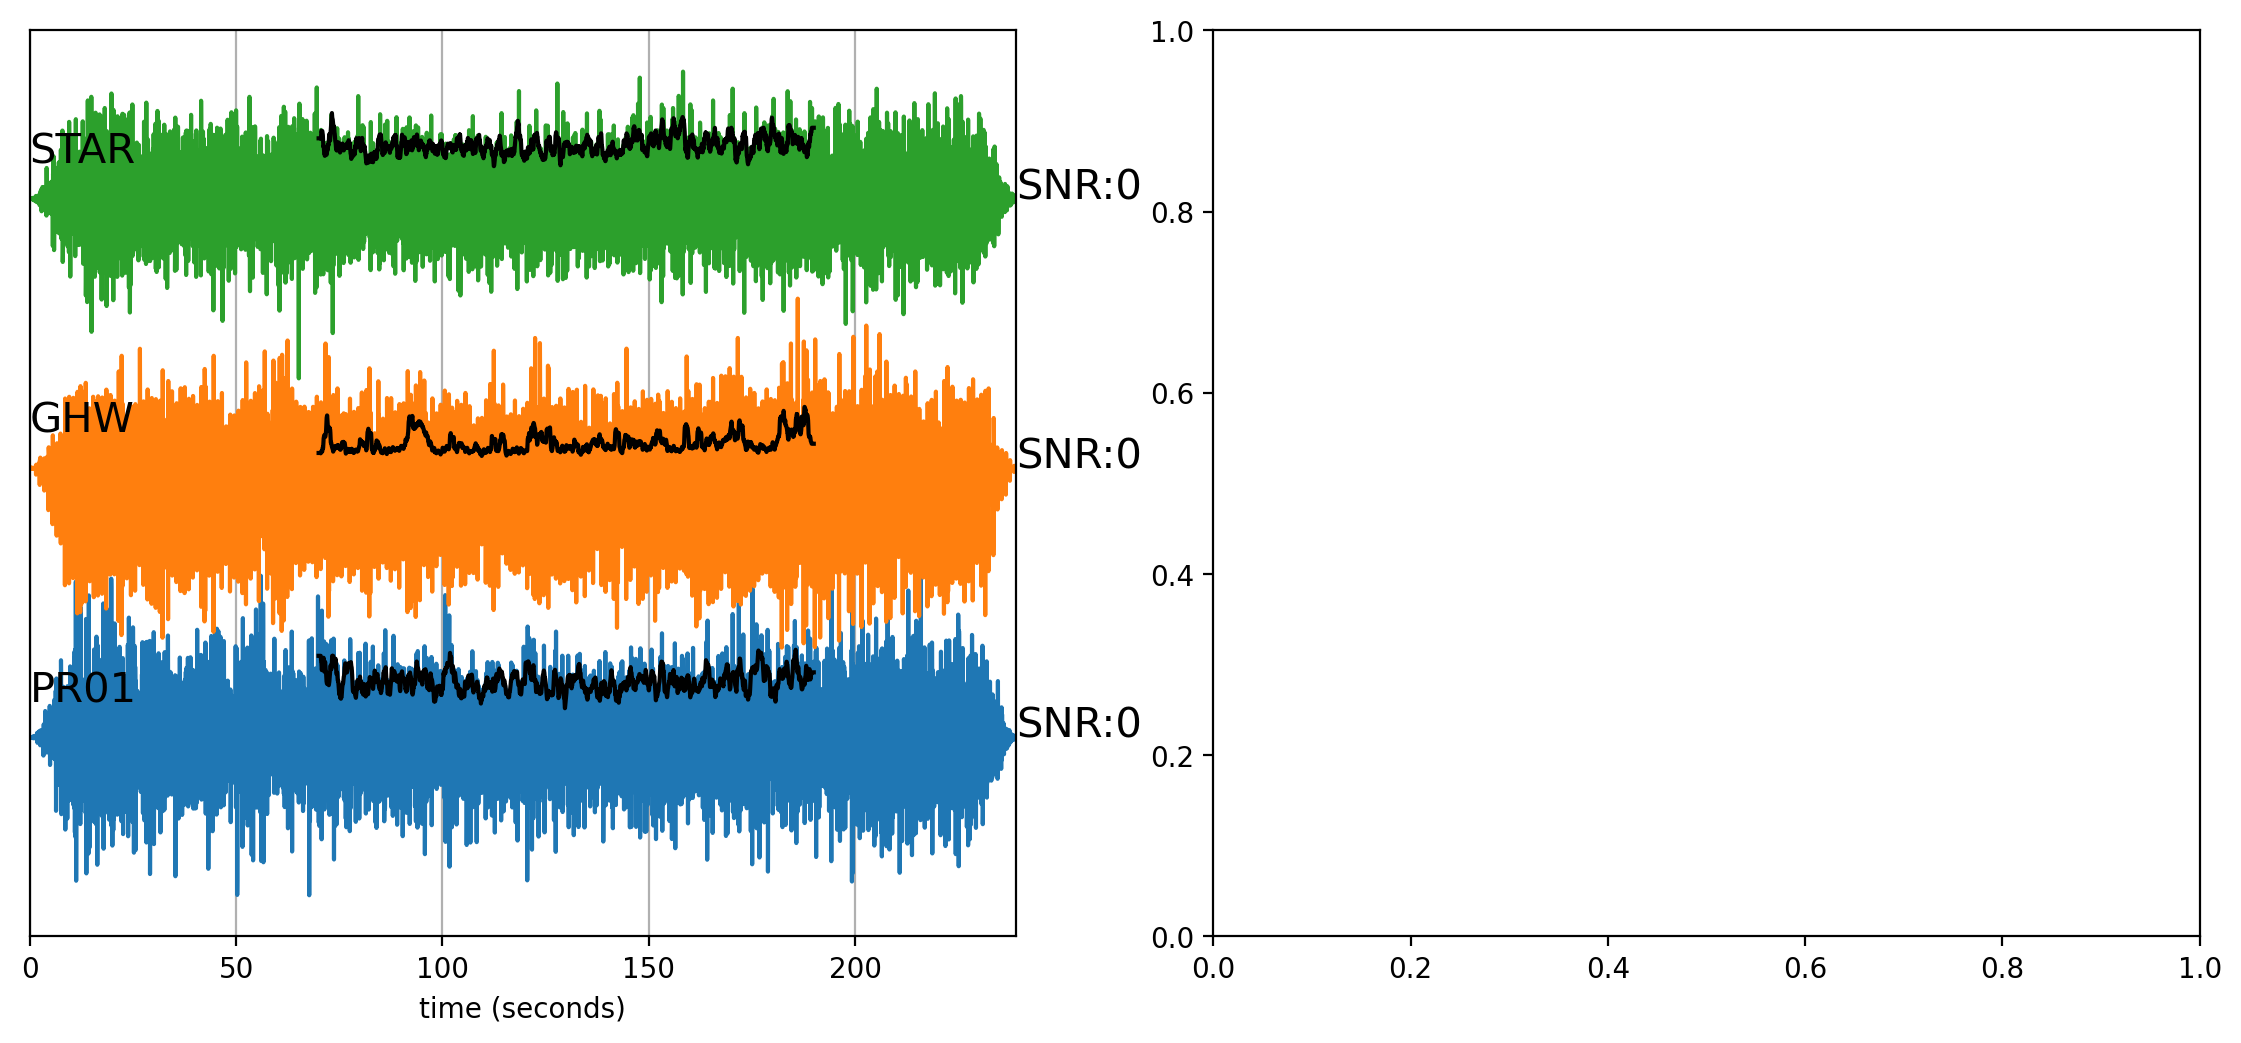

In [45]:
time = UTCDateTime(2021,6,15,0,13)# (year, month, day, hour, minute, seconds)
associated_volcano = 'Mt_Rainier'
label = 'Good on KAUT/PARA/OPCH (Nisqually Icefall w/ photo by Jost)' # string of the label from the catalog
thr = 0
print(time)

#get info for stations within 50km of volcano that event ocurred at
stations = df[df['Volcano_Name'] == associated_volcano]['Station'].values.tolist()
networks = df[df['Volcano_Name'] == associated_volcano]['Network'].values.tolist()
latitudes = df[df['Volcano_Name'] == associated_volcano]['Latitude'].values.tolist()
longitudes = df[df['Volcano_Name'] == associated_volcano]['Longitude'].values.tolist()
elevations = df[df['Volcano_Name']== associated_volcano]['Elevation'].values.tolist()

#Get all waveforms for that event based on stations and times
bulk = [] 
for m in range(0, len(networks)):
    bulk.append([networks[m], stations[m], '*', '*', time-t_before, time+t_after])
st = client.get_waveforms_bulk(bulk)

#remove unwanted data
for tr in st:
    cha = tr.stats.channel
    if cha[0:2] != 'BH' and cha[0:2] != 'EH' and cha[0:2] != 'HH':
        st.remove(tr)
    try:
        if len(tr.data)/tr.stats.sampling_rate < 239.9:
            st.remove(tr)
    except:
        pass

#resampling the data to 40Hz for each trace
st = resample(st,fs) 

#Plotting all traces for one event with channel z, SNR>10, and bandpasses between 2-12Hz
SNR,SNR_weight, no_weight,stas,nets,max_amp_times,durations,data_env_dict,t_diff = [],[],[],[],[],[],[],{},{}

fig, (ax1, ax) = plt.subplots(1, 2, figsize = (14,6), dpi = 200)

iplot = 0
for i,ii in enumerate(st):
    network = ii.stats.network
    station = ii.stats.station
    ii.detrend(type = 'demean')
    ii.filter('bandpass',freqmin=2.0,freqmax=12.0,corners=2,zerophase=True)
    ii2 = ii.copy()
    ii2.filter('bandpass',freqmin=0.5,freqmax=2.0,corners=2,zerophase=True)
    cha = ii.stats.channel
    starttime = ii.stats.starttime
    max_amp_time = np.argmax(ii.data)/fs
    signal_window = ii.copy()
    noise_window = ii.copy()
    signal_window.trim(starttime + t_before - 20 +20 , starttime + t_before - 20 + window + 40)
    noise_window.trim(starttime + t_before - window -15, starttime + t_before - 15)

    snr = (20 * np.log(np.percentile(np.abs(signal_window.data),pr) 
                   / np.percentile(np.abs(noise_window.data),pr))/np.log(10))

    if cha[-1] == 'Z' and snr>thr and 100<max_amp_time<200 and station != 'CINE' and station != 'PUPY' and station != 'TDL':
        t = ii.times()
        t_diff[network+'.'+station] = starttime-time 
        # enveloping the data 
        b,e = 0,239
        data_envelope = obspy.signal.filter.envelope(ii.data[70*fs:190*fs])
        data_envelope /= np.max(data_envelope)

        # finding the time of max amplitude of each event
        max_amp_times.append(max_amp_time)
        max_amp = np.max(ii.data)      
        # creating envelope data dictionary to calculate picktimes
        data_envelope = obspy.signal.util.smooth(data_envelope,20)
        data_env_dict[network+'.'+station]= data_envelope
        ax1.plot(t[b*fs:e*fs],ii.data[b*fs:e*fs]/np.max(np.abs(ii.data))+iplot*1.5)
        ax1.plot(t[70*fs:190*fs], data_envelope+(iplot*1.5), color = 'k')
        ax1.set_xlabel('time (seconds)', fontsize = 10)
        plt.xticks(fontsize = 10)
        ax1.set_xlim([b,e])
        ax1.set_yticks([])
        ax1.text(t[e*fs], iplot*1.5, 'SNR:'+str(int(snr)), fontsize = 15)
        ax1.text(t[b*fs], (iplot*1.5)+0.2, station, fontsize = 15)
        ax1.grid(True)
        iplot = iplot+1
        stas.append(ii.stats.station)
        nets.append(ii.stats.network)
        SNR.append(snr)
        SNR_weight.append(int(snr))
        no_weight.append(1)
    else:
        st.remove(ii)

# # delete repeating stations
# index = 0
# for i in range(len(stas)):
#     if stas[i] == stas[i-1]:
#         net_sta = nets[i]+'.'+stas[i]
#         index = stas.index(stas[i])
# if index != 0:        
#     del stas[index]
#     del nets[index]
#     del SNR[index]
#     del SNR_weight[index]
#     del no_weight[index]

# # if len(st)<4:  
# #     continue

# # read and preprocess data
# st.taper(max_percentage=0.01,max_length=20)
# st.trim(starttime=time-20,endtime=time+30) 

# lats, lons, elevs, r, theta = ([] for i in range(5))

# ref_index = SNR.index(np.max(SNR))
# ref = str(nets[ref_index]+'.'+stas[ref_index])
# try:
#     ref_env = data_env_dict[reference]
# except:
#     print(ref)
#     ref_env = data_env_dict[ref]

# # calculating the picktimes and shift in arrival times using envelope cross_correlation
# pick_times, offsets, starttimes = pick_time(time, ref_env, data_env_dict,st,t_diff, t_before, fs)#calculate picktimes

# shifts, vals = shift(offsets, starttimes, t_diff)

# iplot = 0 
# durations = []
# for i in range(len(stas)):
#     max_amp_time = max_amp_times[i]
#     duration = (max_amp_time-vals[i])*2
#     durations.append(duration)
#     ax1.vlines(vals[i], ymin = iplot*1.5-1, ymax = iplot*1.5+1, color = colors[i])
#     a = stations.index(stas[i])
#     lats.append(latitudes[a])
#     lons.append(longitudes[a])
#     elevs.append(elevations[a])
#     iplot = iplot+1
# avg_duration = np.mean(durations)

# # Determine the peak frequency and make plot of the spectra
# char_freq, sharp_weight= [],[]
# for i in range(len(stas)):
#     data = st.select(station=stas[i],component="Z")[0].data*100
#     f,psd=scipy.signal.welch(data,fs=st[0].stats.sampling_rate,nperseg=81,noverlap=1)
#     #just get the frequencies within the filter band
#     above_low_cut = [f>low_cut]
#     below_high_cut = [f<high_cut]
#     in_band = np.logical_and(above_low_cut,below_high_cut)[0]
#     f = f[in_band]
#     psd = psd[in_band]

#     # calculate characteristic frequency and report
#     char_freq_max = f[np.argmax(psd)]
#     char_freq_mean= np.sum(psd*f)/np.sum(psd)
#     psd_cumsum = np.cumsum(psd)
#     psd_sum = np.sum(psd)
#     char_freq_median = f[np.argmin(np.abs(psd_cumsum-psd_sum/2))]
#     char_freq.append(char_freq_mean)

# #                 plt.yticks(fontsize = 10)
# #                 ax.plot(f,psd,label=stas[i],linewidth=1.5)
# #                 ax.set_xscale('log')
# #                 ax.set_yscale('log')
# #                 ax.tick_params(axis = 'x', which = 'both', labelsize = 10)
# #                 ax.grid('True')
# #                 plt.xticks(fontsize = 10)
# #                 ax.set_xlabel('Frequency [Hz]', fontsize = 10)
# #                 ax.set_ylabel('PSD [$(mm/s)^2$/Hz]', fontsize = 10)
# #                 ax.vlines(char_freq_mean,ymin=np.min(psd)/10,ymax=np.max(psd)*10,linestyle="--",colors=colors[i])
# #         ax.legend(fontsize = 10) 

# # input necessary data for grid search
# arrivals = shifts
# sta_lats = lats
# sta_lons= lons

# # define grid origin in lat,lon and grid dimensions in m
# lat_start = volc_grid[associated_volcano][0]
# lon_start = volc_grid[associated_volcano][1]
# side_length = volc_grid[associated_volcano][2]

# # create the grid of locations
# sta_x = []
# sta_y = []
# for i in range(len(sta_lats)):
#     x_dist = distance.distance([lat_start,lon_start],[lat_start,sta_lons[i]]).m
#     y_dist = distance.distance([lat_start,lon_start],[sta_lats[i],lon_start]).m
#     sta_x.append(x_dist)
#     sta_y.append(y_dist)
# x_vect = np.arange(0, side_length, step)
# y_vect = np.arange(0, side_length, step)
# t0 = np.arange(0,np.max(arrivals),t_step)

# # carry out the gridsearch weighted by SNR
# weight = np.array(SNR_weight)/np.max(SNR_weight)
# rss_mat = gridsearch(t0,x_vect,y_vect,sta_x,sta_y,1000,arrivals,weight)
# loc_idx_snr = np.unravel_index([np.argmin(rss_mat)], rss_mat.shape)

# # gridsearch with no weight
# weight = [1 for i in range(len(SNR_weight))]
# rss_mat = gridsearch(t0,x_vect,y_vect,sta_x,sta_y,1000,arrivals,weight)
# loc_idx = np.unravel_index([np.argmin(rss_mat)], rss_mat.shape)

# # gridsearch weighted with SNR and Slope

# slen = round(volc_grid['Mt_Rainier'][2]/10)
# # get area to index the data over
# a = int((left_x-left)/10) 
# b = a+slen
# c = (slope.shape[0] - int((bottom_y-bottom)/10))-slen
# d = slope.shape[0] - int((bottom_y-bottom)/10)

# x = np.arange(a,b,1)
# y = np.arange(c,d,1)

# x2 = np.arange(a,b,10) # every 100m
# y2 = np.arange(c,d,10) # every 100m

# # index the data 
# slope_data = np.array(slope[c:d,a:b])

# # take out outliars that skew the data
# slope_data[slope_data < 1] = 1
# slope_data[slope_data > 90] = 80

# # normalize so that higher slope values give low error values
# slope_norm = 1/slope_data

# # interpolate the slope data into 100m grid to match grid search 
# slope_interp_mat = RectBivariateSpline(y,x,slope_norm, s = 0)
# interp = slope_interp_mat(x2,y2)/np.max(slope_interp_mat(x2,y2))*0.1+.9

# # calculate the location index 
# rss_mat_slope = np.multiply(rss_mat[loc_idx[0],:,:],interp)
# loc_idx_slope = np.unravel_index([np.argmin(rss_mat_slope)], rss_mat_slope.shape)
# loc_lat_slope, loc_lon_slope, test_d = location(x_vect[loc_idx_slope[1]], y_vect[loc_idx_slope[2]], lat_start, lon_start)

# # find the latitude and longitude of the location index
# loc_lat, loc_lon, d = location(x_vect[loc_idx[1]], y_vect[loc_idx[2]], lat_start, lon_start)
# err_thr = np.min(np.log10(rss_mat))+.05
# thr_array = np.argwhere(np.log10(rss_mat)<err_thr)
# diameter = error_diameter(thr_array)

# # calculating azimuth for each station with respect to the middle of the volcano
# for i in range(len(stas)):
#     u,b,c = (gps2dist_azimuth(loc_lat_slope, loc_lon_slope, lats[i], lons[i], a=6378137.0, f=0.0033528106647474805))
#     r.append(u)
#     theta.append(b)

# bin1,bin2,bin3 = [],[],[]
# for i in theta:
#     if 0<=i<=120:
#         bin1.append(i)
#     if 121<=i<=240:
#         bin2.append(i)
#     if 241<=i<=360:
#         bin3.append(i)
# # if bin1 == [] or bin2 == [] or bin3 == []:
# #     continue

# #manipulating the data
# data = {'azimuth_deg':theta, 'freq':char_freq, 'station':stas, 'distance_m':r, 
#         'SNR':SNR, 'colors':colors[0:len(stas)]}
# DF = pd.DataFrame(data, index = None)
# DF2 = DF.sort_values('azimuth_deg')

# #Taking out stations that are too close to the location when looking at azimuth 
# drops = []
# for i in range(len(DF2)):
#     value = DF2.loc[i,'distance_m']
#     if value < az_thr:
#         drops.append(i)
# DF3 = DF2.drop(drops)
# y_data =  DF3["freq"].values.tolist()
# Sta2 = DF3["station"].values.tolist()
# dist2 = DF3["distance_m"].values.tolist()
# #spike_weight = DF3["weight"].values.tolist()
# SNR2 = DF3['SNR'].values.tolist()
# colors2 = DF3['colors'].values.tolist()
# x_data =  np.asarray(DF3["azimuth_deg"].values.tolist())
# x_points = np.linspace(0, 360, 100)

# # optimizing parameters to fit data to test_function
# params, params_covariance = optimize.curve_fit(test_func, np.deg2rad(x_data), y_data, p0=None)
# perr = np.sqrt(np.diag(params_covariance))
# std_deviation = str(round(perr[0],9))+','+str(round(perr[1],9))+','+str(round(perr[2],9))
# d = test_func(np.deg2rad(x_points), params[0], params[1], params[2])
# len_r = int(max(r))

# # ensures no negative values
# if params[0]<0:
#     direction = params[1]+pi 
# else:
#     direction = params[1]

# # calculating the velocity 
# fmax = max(d)
# fmin = min(d)
# v = v_s*((fmax-fmin)/(fmax+fmin))

# # convert the direction from polar to cartesian coordinates
# dy = len_r*np.sin(direction)
# dx = len_r*np.cos(direction)         

# # weight data by SNR
# title = 'SNR'
# v_snr,direction_snr,d_snr = weight_data(x_data,y_data,SNR_weight,test_func,v_s,stas)  
# dy_snr = len_r*np.sin(direction_snr)
# dx_snr = len_r*np.cos(direction_snr) 

# #             fig,ax = plt.subplots(1,1,figsize=(11,8), dpi = 200)
# #             fig.suptitle('Fitted Cosine Curves', fontsize = 20)       
# #             ax.set_ylabel('characteristic frequency(Hz)', fontsize = 10)
# #             ax.set_xlabel('azimuth(degrees)', fontsize = 10)
# #             for i in range (0,len(Sta2)):
# #                 ax.scatter(x_data[i], y_data[i], s = (SNR_weight[i]**2),label=Sta2[i], color = colors2[i])
# #             ax.plot(x_data,y_data, '--', label='rawdata')
# #             ax.plot(x_points, d, label = 'original')
# #             ax.plot(x_points, d_sharp, label = 'sharpness')
# #             ax.plot(x_points, d_snr, label = 'snr')
# #             ax.legend(loc='upper right', fontsize = 10)
# #             plt.grid(True)

# # convert loc data onto the DEM data
# contour_x,contour_y = np.meshgrid(left_x+x_vect,bottom_y+y_vect)
# center_x, center_y = transform(p1,p2,info[1],info[0])
# loc_x,loc_y=transform(p1,p2,loc_lon_slope,loc_lat_slope)
# duration=avg_duration
# length_factor = duration/100
# length_factor = v_snr/(np.max(v_snr)*5)

# data = r_dem_data_dict[associated_volcano]['data']

# dem = ax.imshow(data,extent=[left, right, bottom, top],cmap='gist_earth', alpha = 0.8)
# contours = ax.contour(contour_x,contour_y,np.log10(rss_mat_slope[int(loc_idx_slope[0]),:,:].T),cmap='plasma', linewidths = 0.7)
# topo_countours = ax.contour(data,levels = [2000,4000,6000,8000], extent=[left, right, bottom, top],origin="upper", colors = 'k',linewidths = 0.4, alpha = 0.6)
# ax.arrow(loc_x,loc_y,dy_snr*length_factor,dx_snr*length_factor, color='w', width=100, zorder = 4)
# ax.scatter(loc_x, loc_y, s=150,marker='*',c='aqua', zorder = 5)

# #plotting the stations on top of this as triangles
# for i, ii in enumerate(stas):
#     sta_x,sta_y = transform(p1,p2,lons[i],lats[i])
#     if left+info[3]<sta_x<right-info[4] and bottom+info[5]<sta_y<top-info[6]:
#         ax.plot(sta_x,sta_y, c='k', marker="^")
#         ax.text(sta_x,sta_y,ii, c='k', fontsize = 15)

# divider = make_axes_locatable(ax)
# cax1 = divider.append_axes('right', size='2%', pad=0.1)
# ax.set_title('Location and Directivity', fontsize = 20)
# ax.set_xlabel('longitudes(DD)', fontsize = 10)
# ax.set_ylabel('latitudes(DD)', fontsize = 10)
# ax.set_xticks(ticks_x)
# ax.set_xticklabels(tick_lons, fontsize = 10)
# ax.set_yticks(ticks_y)
# ax.set_yticklabels(tick_lats, fontsize = 10)
# ax.clabel(contours, contours.levels, fontsize = 15, inline = True, inline_spacing = 0.5)

# cbar = plt.colorbar(dem, cax=cax1)
# cbar.ax.tick_params(labelsize=10)
# cbar.set_label('Elevation(ft)\n', rotation=270, labelpad = 13, fontsize = 10)
# ax.set_xlim(left+info[3],right-info[4])
# ax.set_ylim(bottom+info[5],top-info[6])
# plt.tight_layout()

# #getting lat and lon tick marks on the axis
# tick_lons = lat_lon_dict[associated_volcano]['tick_lons']
# tick_lats = lat_lon_dict[associated_volcano]['tick_lats']
# ticks_x = []
# ticks_y = []
# for i in range(len(tick_lons)):
#     tick_x,tick_y=transform(p1,p2,tick_lons[i],tick_lats[i])
#     ticks_x.append(tick_x)
#     ticks_y.append(tick_y)
#     tick_lons[i]=str(tick_lons[i])
#     tick_lats[i]=str(tick_lats[i])
    
# fig.suptitle(associated_volcano+' velocity:'+str(round(v))+'m/s'+' \n  '+label, fontsize = 15)
# plt.tight_layout()

# plt.savefig('./Analysis_Data/labeled_figs/'+str(time)+'.png') #,bbox_inches="tight")

# # # saving the figures into a zip file
# # save_path = './Analysis_Data/r_events_finalfigs'
# # image_list = []
# # for file in os.listdir(save_path):
# #     if file.endswith(".png"):
# #         image_list.append(os.path.join(save_path, file))

# # with ZipFile(os.path.join(save_path, 'Rainier_labeled_event_figs.zip'), 'w') as zip:
# #     for file in image_list:
# #         zip.write(file)# making a final figure of the map and the waveforms with the label

0 Trace(s) in Stream:
